1. import data from datasheet csv with pandas

In [1]:
import pandas as pd

df = pd.read_csv('XAUUSD_H4.csv')
print(df.head())

                  time     open     high      low    close  tick_volume
0  2023-11-03 16:00:00  2000.23  2001.68  1986.59  1990.35        33547
1  2023-11-03 20:00:00  1990.35  1995.14  1989.88  1992.52        11969
2  2023-11-06 00:00:00  1992.40  1993.14  1987.04  1992.16         8580
3  2023-11-06 04:00:00  1992.18  1993.00  1982.08  1983.95        10625
4  2023-11-06 08:00:00  1983.94  1987.90  1982.32  1986.84        12429


2. predict next candle close, if next price bigger than current price add 1 label, if lower than add label 0

In [2]:
# prediksi arah harga selanjutnya
# label: 1 jika harga berikutnya naik, 0 jika turun
df['next_close'] = df['close'].shift(-1)
df['target'] = (df['next_close'] > df['close']).astype(int)

# baris terakhir karena targetnya NaN
df = df.dropna()
print(df[['close', 'next_close', 'target']].head())

     close  next_close  target
0  1990.35     1992.52       1
1  1992.52     1992.16       0
2  1992.16     1983.95       0
3  1983.95     1986.84       1
4  1986.84     1986.32       0


3. technical code use methode moving average 20

In [22]:
import ta

df['ma20'] = df['close'].rolling(window=20).mean()
df['return_1'] = df['close'].pct_change()
df = df.dropna()

# Tambah RSI
df['rsi'] = ta.momentum.RSIIndicator(df['close']).rsi()

# Tambah MACD
macd = ta.trend.MACD(df['close'])
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()

# Tambah Bollinger Band
bb = ta.volatility.BollingerBands(df['close'])
df['bb_high'] = bb.bollinger_hband()
df['bb_low'] = bb.bollinger_lband()

df = df.dropna()

print(df[['close', 'ma20', 'return_1', 'target']].head())

       close       ma20  return_1  target
170  2032.45  1990.8505  0.002575       1
171  2035.29  1992.4130  0.001397       1
172  2036.64  1994.1370  0.000663       1
173  2037.23  1996.0555  0.000290       0
174  2036.16  1998.1925 -0.000525       1


4. split fitur

In [25]:
X = df[['close', 'ma20', 'return_1', 'rsi']]
y = df['target']
print(X)

        close       ma20  return_1        rsi
170   2032.45  1990.8505  0.002575  69.656148
171   2035.29  1992.4130  0.001397  70.677820
172   2036.64  1994.1370  0.000663  71.174658
173   2037.23  1996.0555  0.000290  71.402717
174   2036.16  1998.1925 -0.000525  70.316182
...       ...        ...       ...        ...
2494  3378.91  3404.9430 -0.004496  45.710667
2495  3386.79  3405.7520  0.002332  48.854528
2496  3382.92  3407.0555 -0.001143  47.402680
2497  3388.47  3407.0750  0.001641  49.710797
2498  3385.80  3407.1740 -0.000788  48.605740

[2329 rows x 4 columns]


4. Train_Test Split

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [27]:
from sklearn.ensemble import RandomForestClassifier as rfc

model = rfc(n_estimators=100, random_state=42, max_depth=10, min_samples_leaf=10, min_samples_split=2, class_weight='balanced')
model.fit(X_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test)
print("Akuarasi : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(df['target'].value_counts())

Akuarasi :  0.4592274678111588
              precision    recall  f1-score   support

           0       0.45      0.87      0.59       208
           1       0.55      0.13      0.21       258

    accuracy                           0.46       466
   macro avg       0.50      0.50      0.40       466
weighted avg       0.50      0.46      0.38       466

target
1    1275
0    1054
Name: count, dtype: int64


In [31]:
# Prediksi arah dari data terakhir
latest_data = df.iloc[-1]
fitur_terakhir = [[latest_data['close'], latest_data['ma20'], latest_data['return_1'], latest_data['rsi']]]
prediksi = model.predict(fitur_terakhir)

print("Prediksi arah selanjutnya:", "Naik" if prediksi[0] == 1 else "Turun")


Prediksi arah selanjutnya: Turun


c:\Users\admal\OneDrive\Desktop\pyhton\sklearn-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


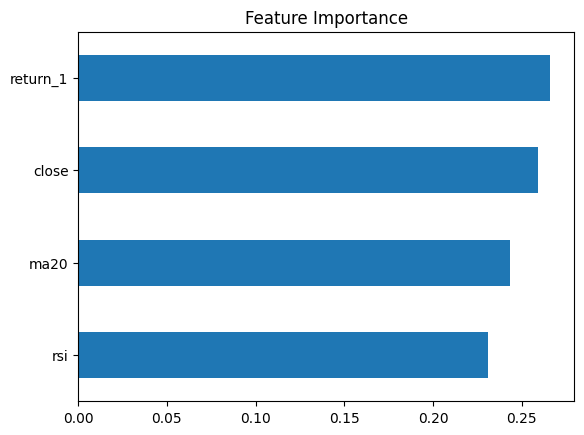

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()
